In [1]:
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from astropy import modeling
set_matplotlib_formats('retina')

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

from inspect import signature

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import  TensorDataset, DataLoader
from torchvision.utils import save_image
import os
from os import listdir
from os.path import isfile, join
# [f for f in listdir('./model') if isfile(join(mypath, f))]

from contrast import small_encoder, added_on_model, parse_option
from losses import SupConLoss
import torch.backends.cudnn as cudnn

import sys
sys.argv=['']
import os
import argparse
import time
import math
import tensorboard_logger as tb_logger
from util import AverageMeter
from util import adjust_learning_rate, warmup_learning_rate, accuracy
from util import set_optimizer, save_model

try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.float_format = '{:.2f}'.format

# data=pd.read_csv("./data_1004.csv")
# data=pd.read_csv("./data1201.csv")
data=pd.read_csv("./data2100205.csv")

columns = data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=data[columns].select_dtypes(include=['float']).columns
object_column = data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

data[not_object[0]] = data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[1]] = data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[2]] = data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[5]] = data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

data[not_object[6]] = data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)


reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']


data.loc[data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = data.loc[data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']
count_label = pd.DataFrame(data.count()/len(data))

count_label.loc[count_label[0]>0.6].index

#list of columns which have at least 60% of non-missing data 

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]

xlist =dict()

for i in range(len(list_04)):
    xlist.update({data[list_04[i]].name: stats.mode(data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    data[list_04[i]] = data[list_04[i]].replace(np.nan, xlist[list_04[i]])

data.loc[data['pleura_bac']>0,'Labeling']=3

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_label']="bacterial"
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_label']="tuberculosis"
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_label']="malignancy"
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_label']="volume"
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_label']="other"

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_int']=0
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_int']=1
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_int']=2
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_int']=3
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_int']=4
data.loc[((data['new_int'].isna())& (data['제외']!=1))
         ,'new_int']=4

### test set process

data.loc[((data['final'].isin([3,17,"3","17"]))& (data['제외']!=1)),'final_label']="bacterial"
data.loc[((data['final'].isin([1,"1"]))& (data['제외']!=1)),'final_label']="tuberculosis"
data.loc[((data['final'].isin([2,"2"]))& (data['제외']!=1)),'final_label']="malignancy"
data.loc[((data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'final_label']="volume"
data.loc[((data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (data['제외']!=1)),'final_label']="other"
data.loc[((data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (data['제외']!=1)),'final_label']="other"
data.loc[((data['final'].isin([9,15,33,34,"9","15","33","34"]))& (data['제외']!=1))
         ,'final_label']="other"

data.loc[((data['final'].isin([3,17,"3","17"]))& (data['제외']!=1)),'final_int']=0
data.loc[((data['final'].isin([1,"1"]))& (data['제외']!=1)),'final_int']=1
data.loc[((data['final'].isin([2,"2"]))& (data['제외']!=1)),'final_int']=2
data.loc[((data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'final_int']=3
data.loc[((data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (data['제외']!=1)),'final_int']=4
data.loc[((data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (data['제외']!=1)),'final_int']=4
data.loc[((data['final'].isin([9,15,33,34,"9","15","33","34"]))& (data['제외']!=1))
         ,'final_int']=4

data['LD_ratio'] = data['LD_pleural fluid']/data['LD']>=0.6
data['LD_raw'] = data['LD_pleural fluid']>= 250*2/3
data['PF_ratio'] = data['Total protein_pleural fluid']/data['Total protein']>=0.6


data['sum_pleural'] = data['LD_ratio'].replace(True, 1).replace(False,0) +data['LD_raw'].replace(True, 1).replace(False,0)+data['PF_ratio'].replace(True, 1).replace(False,0)

data['exudate']= data['sum_pleural']>=1


#previous rule for empyema
data['low_pH']=data['ph_pleural fluid']<7.2
data['low_glu']=data['Glucose_pleural fluid']<61
data['high_LDH']=data['LD_pleural fluid']>1000

data['score']=data['low_pH'].replace(True, 1).replace(False,0)+data['low_glu'].replace(True, 1).replace(False,0)+data['high_LDH'].replace(True, 1).replace(False,0)

data['complicated_pleural_effusion']=data['score']>2


#previous rule for tuberculosis
data['might_Tb']= data['ADA_pleural fluid']>40
data['lymph_dominant'] = data["Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid"]/data["Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid"]>0.75
data.loc[(data['lymph_dominant']==True) & (data['might_Tb']==True),'Tuberculosis']=1

print("whole dataset character for each number")
print("exudate number:", data['exudate'].sum())
print("cancer number :", data['cancer'].sum())
print("complicated pleural effusion number", data['complicated_pleural_effusion'].sum())
print("Tuberculosis_previous number:", data['Tuberculosis'].sum())

whole dataset character for each number
exudate number: 3358
cancer number : 766
complicated pleural effusion number 246
Tuberculosis_previous number: 505.0


### making label to compare with previous rule based criteria 

In [3]:
data['trans_label']=data['final_label']
data.loc[data['Tuberculosis']==True,'trans_label']='rule_tuberculosis'
data.loc[(data['Tuberculosis']==True)&
         (data['final_label']!='tuberculosis'),'trans_label']='not_tuberculosis'
data['trans_int']=data['final_int']
data.loc[data['Tuberculosis']==True,'trans_int']=5
data.loc[(data['Tuberculosis']==True)&
         (data['final_label']!='tuberculosis'),'trans_int']=7

data['trans_label2']=data['final_label']
data.loc[data['complicated_pleural_effusion']==True,'trans_label2']='rule_complicated_effusion'
data.loc[(data['complicated_pleural_effusion']==True)&
         (data['final_label']!='bacterial'),'trans_label2']='not_bacteria'
data['trans_int2']=data['final_int']
data.loc[data['complicated_pleural_effusion']==True,'trans_int2']=6
data.loc[(data['complicated_pleural_effusion']==True)&
         (data['final_label']!='bacterial'),'trans_int2']=8

In [4]:
data = data.loc[data['제외']!=1]

#list 08로 먼저 시도해보자 
training = data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])

# training[col_name]

range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

testset = data.loc[data['final_label'].isna()==False]
#testset = testset.loc[testset['final_label']!="other"]


testset_only = testset[list_04+['final_label','final_int','trans_label','trans_int',
                               'trans_label2','trans_int2']]

for i in col_name:
    testset_only.loc[(testset_only[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    testset_only.loc[(testset_only[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]

scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(testset_only[col_name])
testset_only[col_name] = scaler01.transform(testset_only[col_name])

test_X = torch.tensor(testset_only[col_name].to_numpy(), dtype= torch.float32)
test_Y = torch.tensor(testset_only["final_int"].to_numpy(), dtype= torch.float32)
valid_test_Y = testset_only[['final_label','final_int','trans_label','trans_int','trans_label2','trans_int2']]
valid_test_Y = valid_test_Y.reset_index(drop=True)

### Extravalidation set dimension

In [5]:
print("shape of extravalidation set:", testset_only.shape)

shape of extravalidation set: (701, 52)


### tSNE data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
opt = parse_option()
opt.model_path = './save/{}_{}_models'.format("effu0502_weighted", 20)
loaded_model = torch.load(opt.model_path+"/model_[128, 256, 128, 32]_loss_6.250.pth")
model = small_encoder(46, [128, 256, 128, 32], 20)
model.load_state_dict(loaded_model["model"])
model = model.cuda()
model = model.eval()

for param in model.parameters():
    param.requires_grad = False

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, 
            early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, min_grad_norm=1e-07, 
            metric='euclidean', init='random', verbose=0, 
            random_state=None, method='barnes_hut', angle=0.5)

test_X = test_X.cuda()
X_new = tsne.fit_transform(model(test_X).cpu().numpy())

X_new_l = pd.concat([pd.DataFrame(X_new),valid_test_Y], axis=1)
X_new_l = X_new_l.rename(columns={0:"x", 1:"y"})

In [9]:
colorlist = dict(malignancy=sns.color_palette("Accent",9)[2],
                        volume=sns.color_palette("Accent",9)[4],
                        tuberculosis = sns.color_palette("Accent",9)[5],
                       bacterial = sns.color_palette("Accent",9)[0],
                       other= sns.color_palette("Accent",9)[1],
                       rule_tuberculosis = "#7987FA",
                       not_tuberculosis = "#2F4854",
                       rule_complicated_effusion="#2878EB",
                       not_bacteria = "#3B3A2A")
name = ['other','malignancy','volume','tuberculosis','bacterial']

### t-SNE embedding map of contrastive-loss model with manually annotated data

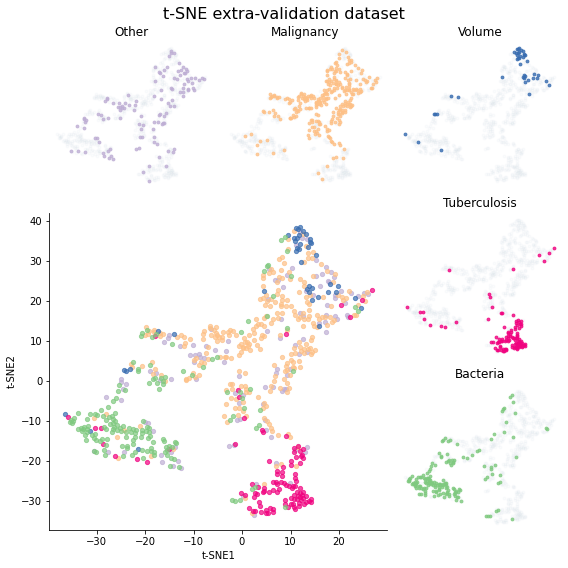

In [10]:
name_title = ['Other','Malignancy','Volume','Tuberculosis','Bacteria']

fig4, f4_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f4_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f4_axs[1:, 1]:
    ax.remove()
for ax in f4_axs[1:, 0]:
    ax.remove()
    
axbig = fig4.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig4.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=X_new_l.loc[X_new_l['final_label']==etiology,"x"].values,
               y=X_new_l.loc[X_new_l['final_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f4_axs[0,j].scatter(x=X_new_l.loc[X_new_l['final_label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['final_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f4_axs[0,j].set_xticks([])
            f4_axs[0,j].set_yticks([])
            f4_axs[0,j].set_xlabel('')
            f4_axs[0,j].set_ylabel('')
            if idx==j:
                f4_axs[0,j].set_title(f'{name_title[idx]}')
            f4_axs[0,j].spines['top'].set_visible(False)
            f4_axs[0,j].spines['right'].set_visible(False)
            f4_axs[0,j].spines['left'].set_visible(False)
            f4_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f4_axs[j-2,2].scatter(x=X_new_l.loc[X_new_l['final_label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['final_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f4_axs[j-2,2].set_xticks([])
            f4_axs[j-2,2].set_yticks([])
            f4_axs[j-2,2].set_xlabel('')
            f4_axs[j-2,2].set_ylabel('')
            if idx==j:
                f4_axs[j-2,2].set_title(f'{name_title[idx]}')
            f4_axs[j-2,2].spines['left'].set_visible(False)
            f4_axs[j-2,2].spines['right'].set_visible(False)
            f4_axs[j-2,2].spines['bottom'].set_visible(False)
            f4_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig4.tight_layout()
fig4.suptitle("t-SNE extra-validation dataset", fontsize=16)
fig4.subplots_adjust(top=0.92)
fig4.savefig("./figures/extraval_tsne_0504.png", dpi=300)

### Comparison with previous rule-based criteria for tuberculosis on t-SNE map

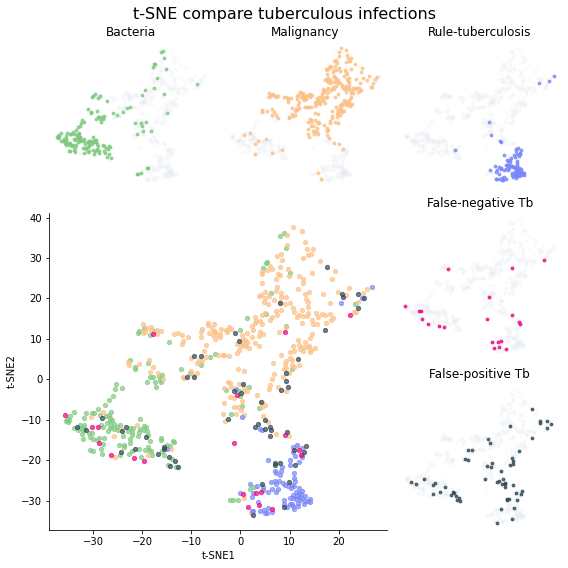

In [11]:
tb_related = ['bacterial', 'malignancy','rule_tuberculosis','tuberculosis','not_tuberculosis',]
title_ = ['Bacteria', 'Malignancy','Rule-tuberculosis','False-negative Tb','False-positive Tb']

fig5, f5_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f5_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f5_axs[1:, 1]:
    ax.remove()
for ax in f5_axs[1:, 0]:
    ax.remove()
    
axbig = fig5.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig5.tight_layout()
for idx, etiology in enumerate(tb_related):
    axbig.scatter(x=X_new_l.loc[X_new_l['trans_label']==etiology,"x"].values,
               y=X_new_l.loc[X_new_l['trans_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f5_axs[0,j].scatter(x=X_new_l.loc[X_new_l['trans_label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['trans_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f5_axs[0,j].set_xticks([])
            f5_axs[0,j].set_yticks([])
            f5_axs[0,j].set_xlabel('')
            f5_axs[0,j].set_ylabel('')
            if idx==j:
                f5_axs[0,j].set_title(f'{title_[idx]}')
            f5_axs[0,j].spines['top'].set_visible(False)
            f5_axs[0,j].spines['right'].set_visible(False)
            f5_axs[0,j].spines['left'].set_visible(False)
            f5_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f5_axs[j-2,2].scatter(x=X_new_l.loc[X_new_l['trans_label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['trans_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f5_axs[j-2,2].set_xticks([])
            f5_axs[j-2,2].set_yticks([])
            f5_axs[j-2,2].set_xlabel('')
            f5_axs[j-2,2].set_ylabel('')
            if idx==j:
                f5_axs[j-2,2].set_title(f'{title_[idx]}')
            f5_axs[j-2,2].spines['left'].set_visible(False)
            f5_axs[j-2,2].spines['right'].set_visible(False)
            f5_axs[j-2,2].spines['bottom'].set_visible(False)
            f5_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
axbig.spines['top'].set_visible(False)

fig5.tight_layout()
fig5.suptitle("t-SNE compare tuberculous infections", fontsize=16)
fig5.subplots_adjust(top=0.92)
fig5.savefig("./figures/extraval_tsne_tb_0504.png", dpi=300)

### Comparison with previous rule-based criteria for empyema on t-SNE map

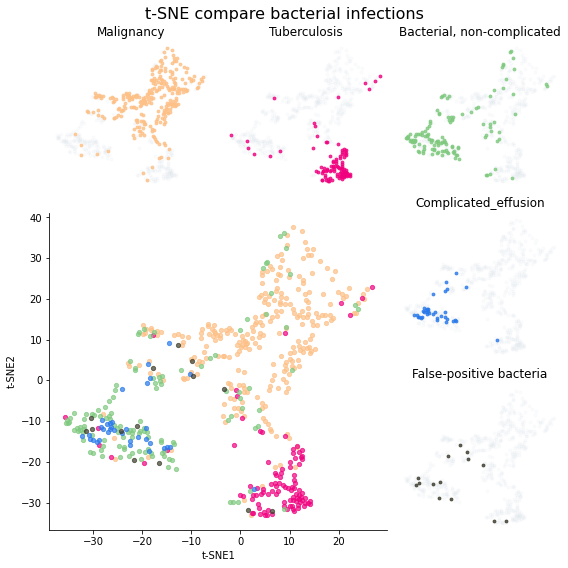

In [12]:
bacteria_related = ['malignancy','tuberculosis','bacterial','rule_complicated_effusion','not_bacteria']
title_b = ['Malignancy','Tuberculosis','Bacterial, non-complicated','Complicated_effusion','False-positive bacteria']

fig6, f6_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f6_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f6_axs[1:, 1]:
    ax.remove()
for ax in f6_axs[1:, 0]:
    ax.remove()
    
axbig = fig6.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig6.tight_layout()
for idx, etiology in enumerate(bacteria_related):
    axbig.scatter(x=X_new_l.loc[X_new_l['trans_label2']==etiology,"x"].values,
               y=X_new_l.loc[X_new_l['trans_label2']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f6_axs[0,j].scatter(x=X_new_l.loc[X_new_l['trans_label2']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['trans_label2']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f6_axs[0,j].set_xticks([])
            f6_axs[0,j].set_yticks([])
            f6_axs[0,j].set_xlabel('')
            f6_axs[0,j].set_ylabel('')
            if idx==j:
                f6_axs[0,j].set_title(f'{title_b[idx]}')
            f6_axs[0,j].spines['top'].set_visible(False)
            f6_axs[0,j].spines['right'].set_visible(False)
            f6_axs[0,j].spines['left'].set_visible(False)
            f6_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f6_axs[j-2,2].scatter(x=X_new_l.loc[X_new_l['trans_label2']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['trans_label2']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f6_axs[j-2,2].set_xticks([])
            f6_axs[j-2,2].set_yticks([])
            f6_axs[j-2,2].set_xlabel('')
            f6_axs[j-2,2].set_ylabel('')
            if idx==j:
                f6_axs[j-2,2].set_title(f'{title_b[idx]}')
            f6_axs[j-2,2].spines['left'].set_visible(False)
            f6_axs[j-2,2].spines['right'].set_visible(False)
            f6_axs[j-2,2].spines['bottom'].set_visible(False)
            f6_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
axbig.spines['top'].set_visible(False)

fig6.tight_layout()
fig6.suptitle("t-SNE compare bacterial infections", fontsize=16)
fig6.subplots_adjust(top=0.92)
fig6.savefig("./figures/extraval_tsne_bac_0504.png", dpi=300)

### predicted effusion on t-sNE embedding map 

In [22]:
classifier_model =  torch.load('./model_classifier0502/model_[128, 5]_582.pt')
# model = torch.load('./simple_model_1223/512_512_4/model_2_634.pt') """model load """
classifier_model = classifier_model.eval()
p_label = classifier_model(test_X.cuda())
predict = torch.argmax(p_label, axis=1)

X_new_predict = pd.concat([X_new_l,pd.DataFrame(predict.cpu().detach().numpy(),columns=['predict'])], axis=1)
X_new_predict.predict = X_new_predict.predict.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

In [23]:
probability = torch.nn.Softmax(dim=1)(p_label).cpu().detach().numpy()

In [24]:
scaler03 = MinMaxScaler(feature_range=(0.01,0.99))
scaler03 = scaler03.fit(p_label.cpu().detach().numpy())

probability3 = scaler03.transform(p_label.cpu().detach().numpy())

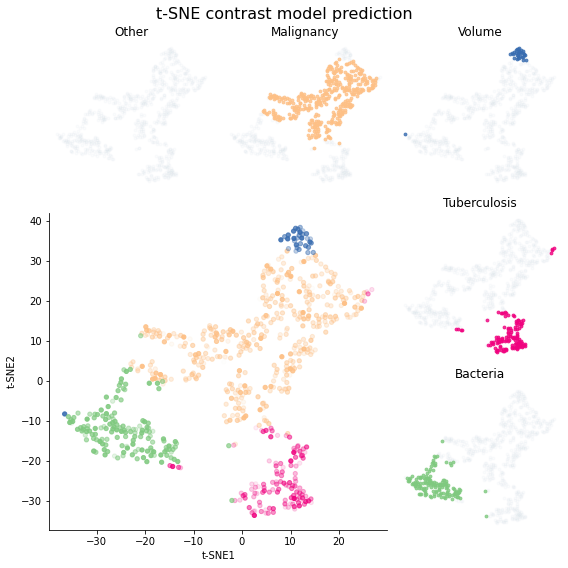

In [25]:
name_title = ['Other','Malignancy','Volume','Tuberculosis','Bacteria']

fig9, f9_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f9_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f9_axs[1:, 1]:
    ax.remove()
for ax in f9_axs[1:, 0]:
    ax.remove()
    
axbig = fig9.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig9.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=X_new_predict.loc[X_new_predict['predict']==etiology,"x"].values,
               y=X_new_predict.loc[X_new_predict['predict']==etiology,"y"].values,
              s=18, alpha=probability3[:,idx], color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f9_axs[0,j].scatter(x=X_new_predict.loc[X_new_predict['predict']==etiology,"x"].values,
                                y=X_new_predict.loc[X_new_predict['predict']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f9_axs[0,j].set_xticks([])
            f9_axs[0,j].set_yticks([])
            f9_axs[0,j].set_xlabel('')
            f9_axs[0,j].set_ylabel('')
            if idx==j:
                f9_axs[0,j].set_title(f'{name_title[idx]}')
            f9_axs[0,j].spines['top'].set_visible(False)
            f9_axs[0,j].spines['right'].set_visible(False)
            f9_axs[0,j].spines['left'].set_visible(False)
            f9_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f9_axs[j-2,2].scatter(x=X_new_predict.loc[X_new_predict['predict']==etiology,"x"].values,
                                y=X_new_predict.loc[X_new_predict['predict']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f9_axs[j-2,2].set_xticks([])
            f9_axs[j-2,2].set_yticks([])
            f9_axs[j-2,2].set_xlabel('')
            f9_axs[j-2,2].set_ylabel('')
            if idx==j:
                f9_axs[j-2,2].set_title(f'{name_title[idx]}')
            f9_axs[j-2,2].spines['left'].set_visible(False)
            f9_axs[j-2,2].spines['right'].set_visible(False)
            f9_axs[j-2,2].spines['bottom'].set_visible(False)
            f9_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig9.tight_layout()
fig9.suptitle("t-SNE contrast model prediction", fontsize=16)
fig9.subplots_adjust(top=0.92)
fig9.savefig("./figures/extraval_tsne_predict0504.png", dpi=300)